# Read DWD CDC Time Series, Merge with Station Description and Append 

The main idea behind this activity is to reformat and merge time series (here we use hourly precipitation) from the DWD Climate Data Center in such a way that it can be used with the **QGIS time manager extension**. 

This extension allows to filter an attribute table of a vector layer (e.g. points representing precipitation stations plus precipitation data) with a time stamp column. The extension limits the attribute table to the records matching the particular time stamp provided by the time manager extension (e.g. by the user moving the time slider). This selected subset of the attribute table is then used to change the sympology of the vector layer according to the variable of interest (e.g. precipitation rate).

The QGIS time manager extension approach is a bit brute force, because each individual measurement at a station at a given time is one feature (row in the table), i.e. a time series at station X with hourly resolution for a day (24 values) entails 24 different features with the same station id and the corresponding coordinates but different times. As of now this 1:n relationship can only be realized by importing a CSV file with the according structure. 

(At least I was not able to generate the required view on a 1:n relationship by merging a point vector layer with precipitation station locations and an imported CSV time series table.)

The final data format is a concatenation of time series together with geographic location in 2D (e.g. lat, lon). The required data format looks principly like this:


| station_id |        name        |   lat   |   lon  |        meas_time       | prec_rate |
|:----------:|:------------------:|:-------:|:------:|:----------------------:|:---------:|
|        ... | ...                |     ... |    ... |                    ... |       ... |
|       1595 | Gelsenkirchen-Buer | 51.5762 | 7.0652 | 2018-12-07T08:00:00UTC |       1.5 |
|       1595 | Gelsenkirchen-Buer | 51.5762 | 7.0652 | 2018-12-07T09:00:00UTC |       1.7 |
|       1595 | Gelsenkirchen-Buer | 51.5762 | 7.0652 | 2018-12-07T10:00:00UTC |       0.1 |
|        ... | ...                |     ... |    ... |                    ... |       ... |
|      13670 | Duisburg-Baerl     | 51.5088 | 6.7018 | 2018-12-07T08:00:00UTC |       0.8 |
|      13670 | Duisburg-Baerl     | 51.5088 | 6.7018 | 2018-12-07T09:00:00UTC |       0.4 |
|      13670 | Duisburg-Baerl     | 51.5088 | 6.7018 | 2018-12-07T10:00:00UTC |       0.0 |
|        ... | ...                |     ... |    ... |                    ... |       ... |


(Table generated with https://www.tablesgenerator.com/markdown_tables)

To achieve this the precipitation time series (station_id, meas_time, prec_rate) have to be merged with the station metadata (station_id, lat, lon) coming from the a CSV file generated in an earlier activity. We use Pandas to read, join and append the data to generate the final CSV file to be imported as a point layer to QGIS. 

This final data format is far from being optimal because of large size and highly redundant information. This is a challenge for QGIS which loses responsiveness with large data. To jsut show the principle it is advisable to limit to size of the problem. 

The following filters (selection criteria) are applied:

  * Precipitation stations in NRW only (approx. 127 stations) 
  * Hourly precipitation data
  * Time interval from 2018-12-01 to last date in precipitation data set 
  
Still: 40 days * 24 hrs / day * 127 stations = 121920 records leading to 121920 features in a point layer in QGIS. 

In fact, the resulting number of records is arround 91000. The reason might be that not all stations in the station list have time series. This has to be checked carefully.

## FTP Connection

### Connection Parameters

In [95]:
server = "opendata.dwd.de"
user   = "anonymous"
passwd = ""


### FTP Directory Definition and Station Description Filename Pattern

In [96]:
# The topic of interest.
topic_dir = "/daily/more_precip/historical/"

# This is the search pattern common to ALL station description file names 
station_desc_pattern = "_Beschreibung_Stationen.txt"

# Below this directory tree node all climate data are stored.
ftp_climate_data_dir = "/climate_environment/CDC/observations_germany/climate/"
ftp_dir =  ftp_climate_data_dir + topic_dir

### Local Directories

In [97]:
local_ftp_dir         = "data/original/DWD/"      # Local directory to store local ftp data copies, the local data source or input data. 
local_ftp_station_dir = local_ftp_dir + topic_dir # Local directory where local station info is located
local_ftp_ts_dir      = local_ftp_dir + topic_dir # Local directory where time series downloaded from ftp are located

local_generated_dir   = "data/generated/DWD/" # The generated of derived data in contrast to local_ftp_dir
local_station_dir     = local_generated_dir + topic_dir # Derived station data, i.e. the CSV file
local_ts_merged_dir   = local_generated_dir + topic_dir # Parallel merged time series, wide data frame with one TS per column
local_ts_appended_dir = local_generated_dir + topic_dir # Serially appended time series, long data frame for QGIS TimeManager Plugin

In [98]:
print(local_ftp_dir)
print(local_ftp_station_dir)
print(local_ftp_ts_dir)
print()
print(local_generated_dir)
print(local_station_dir)
print(local_ts_merged_dir)
print(local_ts_appended_dir)

data/original/DWD/
data/original/DWD//daily/more_precip/historical/
data/original/DWD//daily/more_precip/historical/

data/generated/DWD/
data/generated/DWD//daily/more_precip/historical/
data/generated/DWD//daily/more_precip/historical/
data/generated/DWD//daily/more_precip/historical/


In [99]:
import os
os.makedirs(local_ftp_dir,exist_ok = True) # it does not complain if the dir already exists.
os.makedirs(local_ftp_station_dir,exist_ok = True)
os.makedirs(local_ftp_ts_dir,exist_ok = True)

os.makedirs(local_generated_dir,exist_ok = True)
os.makedirs(local_station_dir,exist_ok = True)
os.makedirs(local_ts_merged_dir,exist_ok = True)
os.makedirs(local_ts_appended_dir,exist_ok = True)

### FTP Connect

In [100]:
import ftplib
ftp = ftplib.FTP(server)
res = ftp.login(user=user, passwd = passwd)
print(res)

230 Login successful.


In [101]:
ret = ftp.cwd(".")

In [102]:
#ftp.quit()

### FTP Grab File Function

In [103]:
def grabFile(ftpfullname,localfullname):
    try:
        ret = ftp.cwd(".") # A dummy action to chack the connection and to provoke an exception if necessary.
        localfile = open(localfullname, 'wb')
        ftp.retrbinary('RETR ' + ftpfullname, localfile.write, 1024)
        localfile.close()
    
    except ftplib.error_perm:
        print("FTP ERROR. Operation not permitted. File not found?")

    except ftplib.error_temp:
        print("FTP ERROR. Timeout.")

    except ConnectionAbortedError:
        print("FTP ERROR. Connection aborted.")



### Generate Pandas Dataframe from FTP Directory Listing

In [104]:
import pandas as pd
import os

def gen_df_from_ftp_dir_listing(ftp, ftpdir):
    lines = []
    flist = []
    try:    
        res = ftp.retrlines("LIST "+ftpdir, lines.append)
    except:
        print("Error: ftp.retrlines() failed. ftp timeout? Reconnect!")
        return
        
    if len(lines) == 0:
        print("Error: ftp dir is empty")
        return
    
    for line in lines:
#        print(line)
        [ftype, fsize, fname] = [line[0:1], int(line[31:42]), line[56:]]
#        itemlist = [line[0:1], int(line[31:42]), line[56:]]
#        flist.append(itemlist)
        
        fext = os.path.splitext(fname)[-1]
        
        if fext == ".zip":
            station_id = int(fname.split("_")[2])
        else:
            station_id = -1 
        
        flist.append([station_id, fname, fext, fsize, ftype])
        
        

    df_ftpdir = pd.DataFrame(flist,columns=["station_id", "name", "ext", "size", "type"])
    return(df_ftpdir)

In [105]:
df_ftpdir = gen_df_from_ftp_dir_listing(ftp, ftp_dir)

In [106]:
df_ftpdir.head(10)

station_id                                               name   ext  \
0          -1  BESCHREIBUNG_obsgermany_climate_daily_more_pre...  .pdf   
1          -1  DESCRIPTION_obsgermany_climate_daily_more_prec...  .pdf   
2          -1           RR_Tageswerte_Beschreibung_Stationen.txt  .txt   
3           1     tageswerte_RR_00001_19120101_19860630_hist.zip  .zip   
4           2     tageswerte_RR_00002_19510101_20061231_hist.zip  .zip   
5           3     tageswerte_RR_00003_18910101_20110331_hist.zip  .zip   
6           4     tageswerte_RR_00004_19510101_19791031_hist.zip  .zip   
7           6     tageswerte_RR_00006_19821101_20181231_hist.zip  .zip   
8           7     tageswerte_RR_00007_19510101_19960131_hist.zip  .zip   
9           8     tageswerte_RR_00008_19310101_19911231_hist.zip  .zip   

      size type  
0    72261    -  
1    71026    -  
2  1202111    -  
3   109677    -  
4    82951    -  
5   162410    -  
6    45468    -  
7    38084    -  
8    69540    -  
9    88001    -

### Dataframe with TS Zip Files

In [107]:
#df_ftpdir["ext"]==".zip"
df_zips = df_ftpdir[df_ftpdir["ext"]==".zip"]
df_zips.set_index("station_id", inplace = True)
df_zips.head(10)

name   ext    size type
station_id                                                                   
1           tageswerte_RR_00001_19120101_19860630_hist.zip  .zip  109677    -
2           tageswerte_RR_00002_19510101_20061231_hist.zip  .zip   82951    -
3           tageswerte_RR_00003_18910101_20110331_hist.zip  .zip  162410    -
4           tageswerte_RR_00004_19510101_19791031_hist.zip  .zip   45468    -
6           tageswerte_RR_00006_19821101_20181231_hist.zip  .zip   38084    -
7           tageswerte_RR_00007_19510101_19960131_hist.zip  .zip   69540    -
8           tageswerte_RR_00008_19310101_19911231_hist.zip  .zip   88001    -
9           tageswerte_RR_00009_19920601_20101231_hist.zip  .zip   31560    -
10          tageswerte_RR_00010_19610101_20050831_hist.zip  .zip   66983    -
12          tageswerte_RR_00012_19410101_20061231_hist.zip  .zip   93793    -

### Download the Station Description File

In [108]:
station_fname = df_ftpdir[df_ftpdir['name'].str.contains(station_desc_pattern)]["name"].values[0]
print(station_fname)

# ALternative
#station_fname2 = df_ftpdir[df_ftpdir["name"].str.match("^.*Beschreibung_Stationen.*txt$")]["name"].values[0]
#print(station_fname2)

RR_Tageswerte_Beschreibung_Stationen.txt


In [109]:
print("grabFile: ")
print("From: " + ftp_dir + station_fname)
print("To:   " + local_ftp_station_dir + station_fname)
grabFile(ftp_dir + station_fname, local_ftp_station_dir + station_fname)

grabFile: 
From: /climate_environment/CDC/observations_germany/climate//daily/more_precip/historical/RR_Tageswerte_Beschreibung_Stationen.txt
To:   data/original/DWD//daily/more_precip/historical/RR_Tageswerte_Beschreibung_Stationen.txt


In [110]:
# extract column names. They are in German (de)
# We have to use codecs because of difficulties with character encoding (German Umlaute)
import codecs

def station_desc_txt_to_csv(txtfile, csvfile):
    file = codecs.open(txtfile,"r","utf-8")
    r = file.readline()
    file.close()
    colnames_de = r.split()
    colnames_de
    
    translate = \
    {'Stations_id':'station_id',
     'von_datum':'date_from',
     'bis_datum':'date_to',
     'Stationshoehe':'altitude',
     'geoBreite': 'latitude',
     'geoLaenge': 'longitude',
     'Stationsname':'name',
     'Bundesland':'state'}
    
    colnames_en = [translate[h] for h in colnames_de]
    
    # Skip the first two rows and set the column names.
    df = pd.read_fwf(txtfile,skiprows=2,names=colnames_en, parse_dates=["date_from","date_to"],index_col = 0)
    
    # write csv
    df.to_csv(csvfile, sep = ";")
    return(df)

In [111]:
basename = os.path.splitext(station_fname)[0]
df_stations = station_desc_txt_to_csv(local_ftp_station_dir + station_fname, local_station_dir + basename + ".csv")
df_stations.head()

date_from    date_to  altitude  latitude  longitude  \
station_id                                                        
1          1912-01-01 1986-06-30       478   47.8413     8.8493   
2          1951-01-01 2006-12-31       138   50.8066     6.0996   
3          1891-01-01 2011-03-31       202   50.7827     6.0941   
4          1951-01-01 1979-10-31       243   50.7683     6.1207   
6          1982-11-01 2020-02-06       455   48.8361    10.0598   

                           name                state  
station_id                                            
1                          Aach    Baden-Württemberg  
2           Aachen (Kläranlage)  Nordrhein-Westfalen  
3                        Aachen  Nordrhein-Westfalen  
4                  Aachen-Brand  Nordrhein-Westfalen  
6            Aalen-Unterrombach    Baden-Württemberg

### Select Stations Located in NRW from Station Description Dataframe

In [112]:
station_ids_selected = df_stations[df_stations['state'].str.contains("Nordrhein")].index
station_ids_selected

Int64Index([    2,     3,     4,    38,    42,    79,    98,   104,   110,
              186,
            ...
            15456, 15559, 15919, 15927, 15963, 15980, 16087, 19042, 19043,
            19125],
           dtype='int64', name='station_id', length=500)

In [113]:
# Create variable with TRUE if state is Nordrhein-Westfalen
isNRW = df_stations['state'] == "Nordrhein-Westfalen"

# Create variable with TRUE if date_to is latest date (indicates operation up to now)
isOperational = df_stations['date_to'] == df_stations.date_to.max() 

isBefore1950 = df_stations['date_from'] < '1950'

# select on both conditions
dfNRW = df_stations[isNRW & isOperational & isBefore1950]
print("Number of stations in NRW: \n", dfNRW.count())
dfNRW

Number of stations in NRW: 
 date_from    74
date_to      74
altitude     74
latitude     74
longitude    74
name         74
state        74
dtype: int64


date_from    date_to  altitude  latitude  longitude  \
station_id                                                        
79         1931-01-01 2020-02-06       160   50.6718     7.0155   
110        1931-01-01 2020-02-06        65   52.0487     7.4877   
187        1941-01-01 2020-02-06       265   51.4188     7.9126   
389        1931-01-01 2020-02-06       436   51.0148     8.4318   
488        1941-01-01 2020-02-06       127   51.9394     8.5932   
...               ...        ...       ...       ...        ...   
5486       1931-01-01 2020-02-06        93   51.7161     7.6834   
5513       1891-01-01 2020-02-06        92   52.2902     7.8687   
5579       1941-01-01 2020-02-06       275   51.5860     9.0303   
5619       1931-01-01 2020-02-06       360   51.1636     7.4234   
5717       1937-01-01 2020-02-06       134   51.2256     7.1052   

                                   name                state  
station_id                                                    
79                  Alfter-Volmershoven  Nordrhein-Westfalen  
110                          Altenberge  Nordrhein-Westfalen  
187                     Arnsberg-Holzen  Nordrhein-Westfalen  
389               Berleburg, Bad-Arfeld  Nordrhein-Westfalen  
488                Bielefeld-Sennestadt  Nordrhein-Westfalen  
...                                 ...                  ...  
5486                       Werne-Wessel  Nordrhein-Westfalen  
5513                      Westerkappeln  Nordrhein-Westfalen  
5579        Willebadessen-Borlinghausen  Nordrhein-Westfalen  
5619               Wipperfürth-Gardeweg  Nordrhein-Westfalen  
5717              Wuppertal-Buchenhofen  Nordrhein-Westfalen  

[74 rows x 7 columns]

In [114]:
list_lon=[]
list_lat=[]
for index,row in dfNRW.iterrows():
    list_lon.append(row['longitude'])
    list_lat.append(row['latitude'])
print(list_lon)
print(list_lat)

[7.0155, 7.4877, 7.9126, 8.4318, 8.5932, 6.5365, 9.2324, 6.8863, 9.1738, 8.1257, 7.1585, 6.5615, 6.7849, 6.851, 7.5637, 8.0607, 6.3278, 8.2824, 8.1565, 6.9677, 6.7905, 6.2463, 7.0652, 8.3577, 6.5839, 8.2094, 6.9941, 6.5495, 7.3954, 9.426, 7.3656, 6.3431, 8.4891, 6.5264, 7.6536, 6.0954, 7.1575, 7.9682, 8.7749, 8.0348, 6.9777, 8.9009, 7.8699, 8.8388, 8.6477, 8.862, 8.7125, 8.2709, 8.0639, 6.2083, 7.7155, 6.7605, 9.1115, 7.3564, 7.8482, 8.5906, 7.0907, 8.4342, 8.7521, 8.1808, 8.2672, 6.3124, 7.093, 6.9707, 7.3411, 8.3456, 8.2637, 8.2665, 7.1867, 7.6834, 7.8687, 9.0303, 7.4234, 7.1052]
[50.6718, 52.0487, 51.4188, 51.0148, 51.9394, 51.8293, 51.5677, 51.873, 51.7049, 50.7556, 51.9618, 50.4115, 51.5765, 51.1157, 52.1703, 51.8418, 51.0713, 51.0148, 51.254, 51.4041, 50.7119, 51.4942, 51.5762, 51.8771, 51.7217, 51.9753, 51.3393, 50.6086, 50.7263, 51.7882, 51.1434, 50.9316, 51.1803, 50.5014, 51.5854, 51.7612, 50.8646, 50.983, 51.9446, 51.1333, 50.9894, 51.6153, 52.1211, 51.7855, 52.3452, 51.405, 

In [115]:
from geopy import distance
from geopy import Point

# mystation = point("6.94 51.5496")
# print (lon)

list_dist_station=[]

for f, b in zip(list_lon, list_lat):
    myP= str(f)+" "+str(b)
    mystation = Point(myP)
    xanten = Point("6.3974 51.6970")

    result = distance.distance(mystation,xanten).kilometers
    list_dist_station.append(result)
print(list_dist_station)
l1 = sorted(list_dist_station)[:3]
l1
res = [list_dist_station.index(i) for i in l1]
stations_dist_min_df=dfNRW.iloc[res]

[132.36433508187835, 126.6857917653716, 170.36253946318504, 237.2588202996927, 244.30998794007667, 21.232043092587347, 313.86097907150787, 57.46299289067693, 307.0568178402105, 217.57796240358365, 89.11479717042778, 143.34647808633096, 44.87735079955431, 81.53745185407816, 139.18149486274788, 184.64134306102332, 69.6529907190314, 221.65648581604495, 200.59867308835712, 70.89793529989335, 117.29355712687895, 27.977420356931756, 75.0495541266659, 217.70468915139918, 20.80491646815614, 202.73565387737023, 76.9326332483316, 121.56205135508105, 153.91651899040193, 335.1006209987919, 123.32192105907524, 84.89398264220101, 238.2546178725058, 133.02076569755425, 139.47044963416542, 34.144709391551004, 124.63285252349986, 190.77902818435126, 264.3523344986205, 191.48568178992636, 101.19014699098639, 277.0190655586124, 169.4501816720682, 270.18059085118097, 258.94561670097437, 274.467367560911, 262.59848572416075, 210.9419026317163, 185.67869902416876, 131.882639626697, 172.33694731776797, 133.2

In [116]:
stations_dist_min_df
# i got kleve for on the basis of minimum distance
# for measuring the temperature

date_from    date_to  altitude  latitude  longitude  \
station_id                                                        
1999       1931-01-01 2020-02-06        23   51.7217     6.5839   
554        1946-01-01 2020-02-06        23   51.8293     6.5365   
1590       1941-01-01 2020-02-06        37   51.4942     6.2463   

                                    name                state  
station_id                                                     
1999               Hamminkeln-Mühlenrott  Nordrhein-Westfalen  
554         Bocholt-Liedern (Wasserwerk)  Nordrhein-Westfalen  
1590                     Geldern-Walbeck  Nordrhein-Westfalen

In [117]:
print(df_zips)

                                                      name   ext    size type
station_id                                                                   
1           tageswerte_RR_00001_19120101_19860630_hist.zip  .zip  109677    -
2           tageswerte_RR_00002_19510101_20061231_hist.zip  .zip   82951    -
3           tageswerte_RR_00003_18910101_20110331_hist.zip  .zip  162410    -
4           tageswerte_RR_00004_19510101_19791031_hist.zip  .zip   45468    -
6           tageswerte_RR_00006_19821101_20181231_hist.zip  .zip   38084    -
...                                                    ...   ...     ...  ...
19042       tageswerte_RR_19042_18980601_19401231_hist.zip  .zip   63442    -
19043       tageswerte_RR_19043_19410101_19700731_hist.zip  .zip   44469    -
19044       tageswerte_RR_19044_19060901_20050331_hist.zip  .zip   87399    -
19086       tageswerte_RR_19086_18991001_19891231_hist.zip  .zip  131370    -
19087       tageswerte_RR_19087_19570501_19951130_hist.zip  .zip

### Download TS Data from FTP Server

Problem: Not all stations listed in the station description file are associated with a time series (zip file)! The stations in the description file and the set of stations whoch are TS data provided for (zip files) do not match perfectly.  

In [118]:
# list(dfNRW.index)

In [119]:
list (stations_dist_min_df.index)

[1999, 554, 1590]

In [120]:
# Add the names of the zip files only to a list. 
local_zip_list = []
# modification line 
station_ids_selected = list(stations_dist_min_df.index)
print(station_ids_selected)

# station_ids_selected = list(dfNRW.index)

for station_id in station_ids_selected:
    try:
        fname = df_zips["name"][station_id]
        print(fname)
        grabFile(ftp_dir + fname, local_ftp_ts_dir + fname)
        local_zip_list.append(fname)
    except:
        print("WARNING: TS file for key %d not found in FTP directory." % station_id)
print(local_zip_list)

[1999, 554, 1590]
tageswerte_RR_01999_19310101_20181231_hist.zip
tageswerte_RR_00554_19460101_20181231_hist.zip
tageswerte_RR_01590_19410101_20181231_hist.zip
['tageswerte_RR_01999_19310101_20181231_hist.zip', 'tageswerte_RR_00554_19460101_20181231_hist.zip', 'tageswerte_RR_01590_19410101_20181231_hist.zip']


### Join (Merge) the Time Series Columns

https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd


In [121]:
def prec_ts_to_df(fname):
    
    dateparse = lambda dates: [pd.datetime.strptime(str(d), '%Y%m%d%H') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse, na_values = [-999.0, -999])

    #df = pd.read_csv(fname, delimiter=";", encoding="iso8859_2",\
    #             index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse)
    
    # https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd

    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return(df)

In [122]:
def temp_ts_to_df(fname):
    
    dateparse = lambda dates: [pd.datetime.strptime(str(d), '%Y%m%d') for d in dates]

    df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse, na_values = [-999.0, -999])

    #df = pd.read_csv(fname, delimiter=";", encoding="iso8859_2",\
    #             index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparse)
    
    # https://medium.com/@chaimgluck1/working-with-pandas-fixing-messy-column-names-42a54a6659cd

    # Column headers: remove leading blanks (strip), replace " " with "_", and convert to lower case.
    df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
    df.index.name = df.index.name.strip().lower().replace(' ', '_').replace('(', '').replace(')', '')
    return(df)

In [123]:
from zipfile import ZipFile

In [124]:
def ts_merge():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = prec_ts_to_df(myfile)
                s = dftmp["r1"].rename(dftmp["stations_id"][0]).to_frame()
                # outer merge.
                df = pd.merge(df, s, left_index=True, right_index=True, how='outer')

    #df.index.names = ["year"]
    df.index.rename(name = "time", inplace = True)
    return(df)

In [125]:
def percip_ts_merge(start,end):
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = temp_ts_to_df(myfile)
                
                sensing_1=(dftmp.index >= start) & (dftmp.index <= end)
                df_sensing_1=dftmp.loc[sensing_1]
                print(df_sensing_1)
                
                s = df_sensing_1["rs"].rename(df_sensing_1["stations_id"][0]).to_frame()
                
#                 station id column key zero index py data hy us ko user kr k 
#                 dftmp ky ja_tt column ko name krta hi 
                
                print(s)
                # outer merge.
                df = pd.merge(df, s, left_index=True, right_index=True, how='outer')

    #df.index.names = ["year"]
    df.index.rename(name = "time", inplace = True)
    return(df)

In [126]:
df_merged_ts = percip_ts_merge('2015-05-01','2016-05-01')
df_merged_ts2 = percip_ts_merge('2016-05-26','2017-05-26')
df_merged_ts3 = percip_ts_merge('2017-06-30','2018-06-30')

x=df_merged_ts[1590].mean(axis=0)
y=df_merged_ts2[1590].mean(axis=0)
z=df_merged_ts3[1590].mean(axis=0)

list_precip_mean=[x,y,z]
print(list_precip_mean)

Zip archive: data/original/DWD//daily/more_precip/historical/tageswerte_RR_01999_19310101_20181231_hist.zip
Extract product file: produkt_nieder_tag_19310101_20181231_01999.txt

            stations_id  qn_6   rs  rsf  sh_tag  nsh_tag  eor
mess_datum                                                   
2015-05-01         1999     9  0.0    0     0.0      0.0  eor
2015-05-02         1999     9  0.0    0     0.0      0.0  eor
2015-05-03         1999     9  6.6    6     0.0      0.0  eor
2015-05-04         1999     9  6.3    6     0.0      0.0  eor
2015-05-05         1999     9  4.0    6     0.0      0.0  eor
...                 ...   ...  ...  ...     ...      ...  ...
2016-04-27         1999     9  6.3    8     0.0      0.0  eor
2016-04-28         1999     9  0.7    8     0.0      0.0  eor
2016-04-29         1999     9  7.4    6     0.0      0.0  eor
2016-04-30         1999     9  0.1    6     0.0      0.0  eor
2016-05-01         1999     9  0.0    0     0.0      0.0  eor

[367 rows x 7 c

            stations_id  qn_6    rs  rsf  sh_tag  nsh_tag  eor
mess_datum                                                    
2017-06-30          554     3  13.4  4.0     NaN      NaN  eor
2017-07-01          554     3   0.3  4.0     NaN      NaN  eor
2017-07-02          554     3   0.9  4.0     NaN      NaN  eor
2017-07-03          554     3   2.3  4.0     NaN      NaN  eor
2017-07-04          554     3   0.0  0.0     NaN      NaN  eor
...                 ...   ...   ...  ...     ...      ...  ...
2018-06-26          554     3   0.0  0.0     NaN      NaN  eor
2018-06-27          554     3   0.0  0.0     NaN      NaN  eor
2018-06-28          554     3   0.0  0.0     NaN      NaN  eor
2018-06-29          554     3   0.0  0.0     NaN      NaN  eor
2018-06-30          554     3   0.0  0.0     NaN      NaN  eor

[366 rows x 7 columns]
             554
mess_datum      
2017-06-30  13.4
2017-07-01   0.3
2017-07-02   0.9
2017-07-03   2.3
2017-07-04   0.0
...          ...
2018-06-26   0.0
2018

In [127]:
# df_merged_ts = percip_ts_merge()

In [128]:
df_merged_ts

1999  554   1590
time                        
2015-05-01   0.0   0.0   0.0
2015-05-02   0.0   0.0   0.0
2015-05-03   6.6   6.3   6.5
2015-05-04   6.3   5.3   3.1
2015-05-05   4.0   1.3   1.2
...          ...   ...   ...
2016-04-27   6.3   3.6   6.1
2016-04-28   0.7   2.8   2.4
2016-04-29   7.4   9.2   5.2
2016-04-30   0.1   0.0   0.2
2016-05-01   0.0   0.0   0.0

[367 rows x 3 columns]

In [129]:
%matplotlib inline

In [130]:
import matplotlib.pyplot as plt

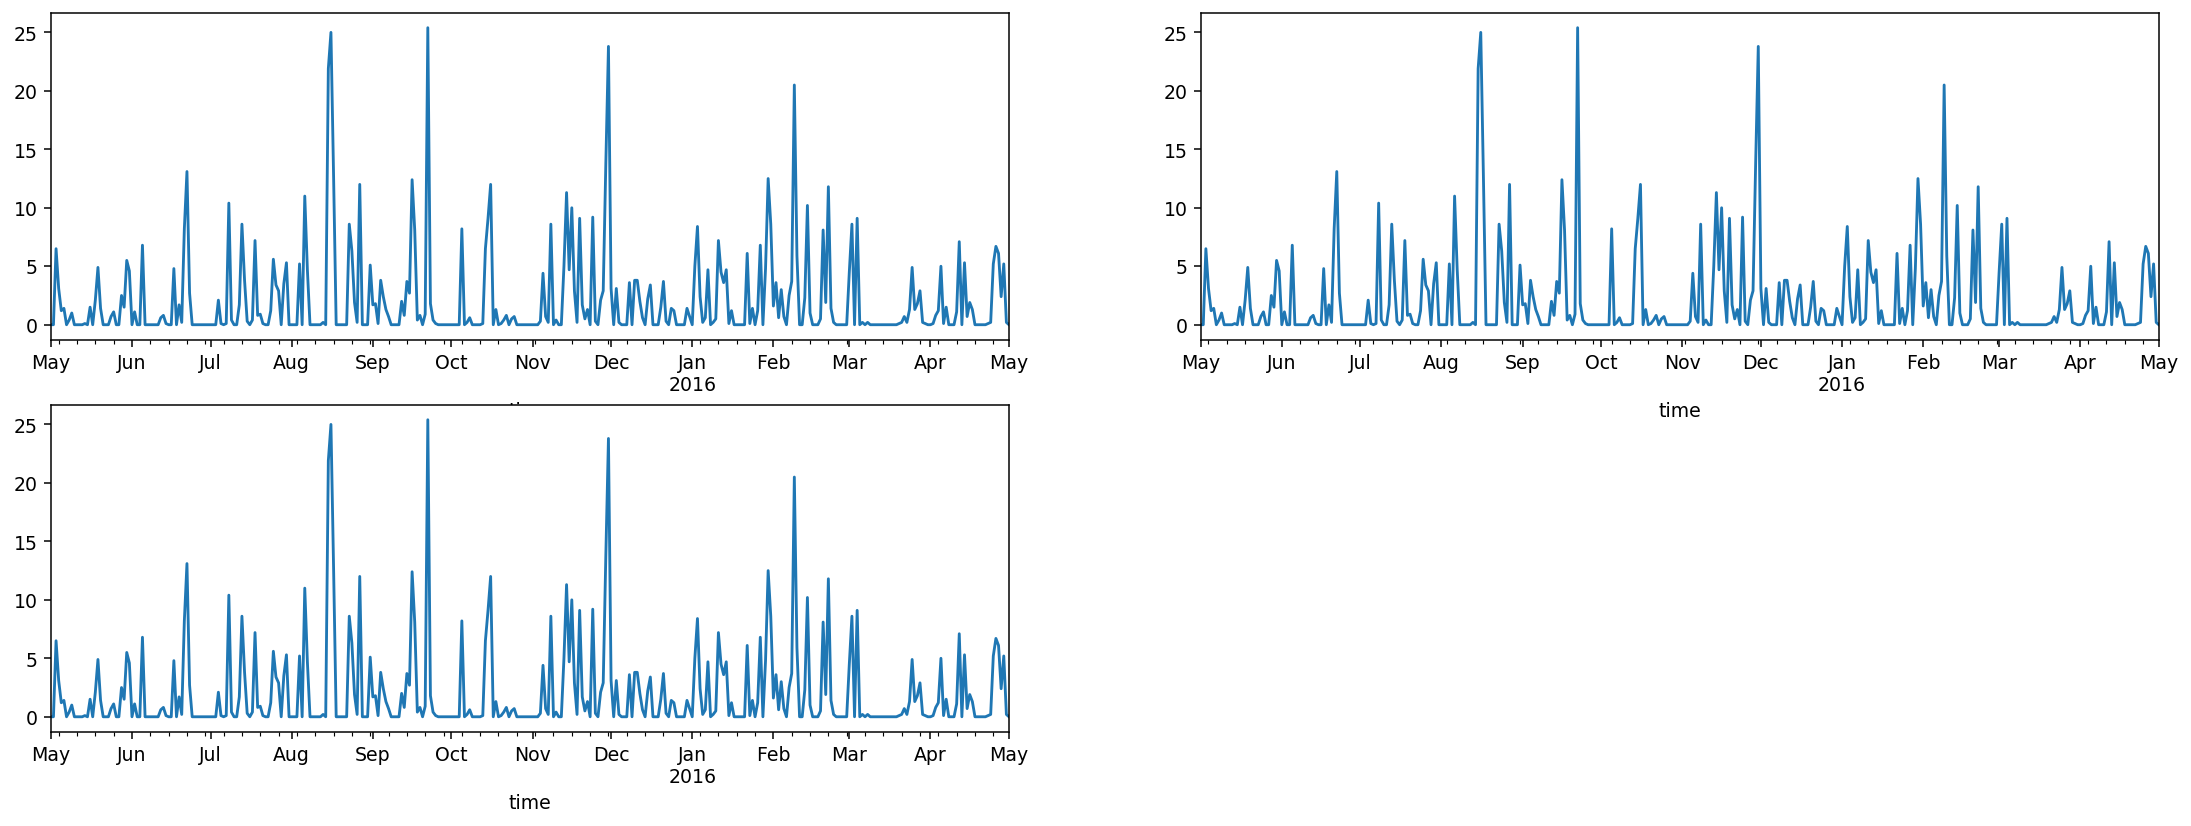

In [131]:
fig = plt.figure(dpi= 136, figsize=(20,7))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
df_merged_ts[1590].plot(ax = ax1)
df_merged_ts[1590].plot(ax = ax2)
df_merged_ts[1590].plot(ax = ax3)
plt.show()

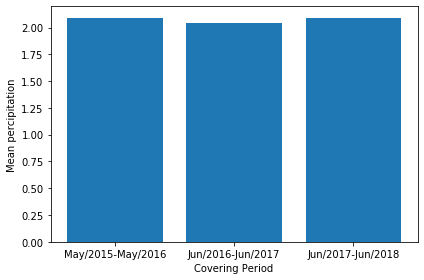

In [132]:
import numpy as np

y_pos = np.arange(len(list_precip_mean))
plt.ylabel('Mean percipitation')
plt.xlabel('Covering Period')
names=['May/2015-May/2016','Jun/2016-Jun/2017','Jun/2017-Jun/2018']
plt.bar(y_pos, list_precip_mean)
plt.xticks(y_pos,names)
plt.tight_layout()
plt.show()

In [133]:
# import seaborn as sns
# import matplotlib.pyplot as plt
# %matplotlib inline

# # plot
# sns.set_style('ticks')
# fig1, ax1 = plt.subplots(dpi = 400, figsize = (12,24))

# #sns.heatmap(df_merged_ts, cmap='RdYlGn_r', annot=False, ax = ax1)
# sns.heatmap(df_merged_ts, cmap='coolwarm', annot=True, vmin = 8, vmax = 12, ax = ax1)

# # _r reverses the normal order of the color map 'RdYlGn'

# #sns.heatmap(df, cmap='coolwarm', annot=True, vmin = 8, vmax = 12, ax = ax)
# ax1.set_yticklabels(df_merged_ts.index.strftime('%Y'))
# plt.show()
# fig1.savefig('example1.png')

In [134]:
df_merged_ts.to_csv(local_ts_merged_dir + "percip_merged.csv",sep=";")

In [135]:
df_merged_ts_transposed = df_merged_ts.transpose()

In [136]:
df_merged_ts_transposed.index.names = ['station_id']

In [137]:
df_merged_ts_transposed.head()

time        2015-05-01  2015-05-02  2015-05-03  2015-05-04  2015-05-05  \
station_id                                                               
1999               0.0         0.0         6.6         6.3         4.0   
554                0.0         0.0         6.3         5.3         1.3   
1590               0.0         0.0         6.5         3.1         1.2   

time        2015-05-06  2015-05-07  2015-05-08  2015-05-09  2015-05-10  ...  \
station_id                                                              ...   
1999               2.5         2.5         0.0         1.1         0.0  ...   
554                1.8         3.1         0.4         0.1         0.0  ...   
1590               1.4         0.0         0.4         1.0         0.0  ...   

time        2016-04-22  2016-04-23  2016-04-24  2016-04-25  2016-04-26  \
station_id                                                               
1999               0.0         0.0         3.7         6.3         9.9   
554                0.0         0.8         4.2         7.1         6.1   
1590               0.0         0.1         0.2         5.2         6.7   

time        2016-04-27  2016-04-28  2016-04-29  2016-04-30  2016-05-01  
station_id                                                              
1999               6.3         0.7         7.4         0.1         0.0  
554                3.6         2.8         9.2         0.0         0.0  
1590               6.1         2.4         5.2         0.2         0.0  

[3 rows x 367 columns]

In [138]:
df_merged_ts_transposed.to_csv(local_ts_merged_dir + "percip_merged_transposed.csv",sep=";")

In [139]:
def ts_append():
    # Very compact code.
    df = pd.DataFrame()
    for elt in local_zip_list:
        ffname = local_ftp_ts_dir + elt
        print("Zip archive: " + ffname)
        with ZipFile(ffname) as myzip:
            # read the time series data from the file starting with "produkt"
            prodfilename = [elt for elt in myzip.namelist() if elt.split("_")[0]=="produkt"][0] 
            print("Extract product file: %s" % prodfilename)
            print()
            with myzip.open(prodfilename) as myfile:
                dftmp = temp_ts_to_df(myfile)
                dftmp = dftmp.merge(df_stations,how="inner",left_on="stations_id",right_on="station_id",right_index=True)
#                print(dftmp.head(5))
                df = df.append(dftmp)

    #df.index.names = ["year"]
    #df.index.rename(name = "time", inplace = True)
    return(df)

In [140]:
df_appended_ts = ts_append()

Zip archive: data/original/DWD//daily/more_precip/historical/tageswerte_RR_01999_19310101_20181231_hist.zip
Extract product file: produkt_nieder_tag_19310101_20181231_01999.txt

Zip archive: data/original/DWD//daily/more_precip/historical/tageswerte_RR_00554_19460101_20181231_hist.zip
Extract product file: produkt_nieder_tag_19460101_20181231_00554.txt

Zip archive: data/original/DWD//daily/more_precip/historical/tageswerte_RR_01590_19410101_20181231_hist.zip
Extract product file: produkt_nieder_tag_19410101_20181231_01590.txt



In [141]:
df_appended_ts.head()

stations_id  qn_6    rs  rsf  sh_tag  nsh_tag  eor  date_from  \
mess_datum                                                                  
1931-01-01         1999     5   7.9  1.0     NaN      NaN  eor 1931-01-01   
1931-01-02         1999     5   0.1  1.0     NaN      NaN  eor 1931-01-01   
1931-01-03         1999     5  14.0  1.0     NaN      NaN  eor 1931-01-01   
1931-01-04         1999     5   2.1  1.0     NaN      NaN  eor 1931-01-01   
1931-01-05         1999     5   2.9  1.0     NaN      NaN  eor 1931-01-01   

              date_to  altitude  latitude  longitude                   name  \
mess_datum                                                                    
1931-01-01 2020-02-06        23   51.7217     6.5839  Hamminkeln-Mühlenrott   
1931-01-02 2020-02-06        23   51.7217     6.5839  Hamminkeln-Mühlenrott   
1931-01-03 2020-02-06        23   51.7217     6.5839  Hamminkeln-Mühlenrott   
1931-01-04 2020-02-06        23   51.7217     6.5839  Hamminkeln-Mühlenrott   
1931-01-05 2020-02-06        23   51.7217     6.5839  Hamminkeln-Mühlenrott   

                          state  
mess_datum                       
1931-01-01  Nordrhein-Westfalen  
1931-01-02  Nordrhein-Westfalen  
1931-01-03  Nordrhein-Westfalen  
1931-01-04  Nordrhein-Westfalen  
1931-01-05  Nordrhein-Westfalen

In [142]:
df_appended_ts.to_csv(local_ts_appended_dir + "percip_appended.csv",sep=";")